# Import Libraries and Load Data 

In [1]:
from Libraries import *

In [2]:
df = pd.read_csv(r'zillow_data.csv')
df.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900


In [3]:
florida_data = df[df['State'] == 'FL']

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn import metrics
import warnings
import itertools
from statsmodels.tsa.stattools import adfuller
from numpy import log
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=13,8

def clean_df_zipcode_index(dataframe):
    fl_df = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df.set_index('Zipcode', inplace=True)
    return fl_df

def clean_df_int_index(dataframe):    
    fl_df_ = dataframe.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    fl_df_.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_df_ = fl_df_.reset_index(drop=True)
    return fl_df_

def clean_dict(dataframe):
    fl_dict = dataframe.drop(dataframe.columns[dataframe.columns.str.contains('-')], axis=1)
    fl_dict = fl_dict.drop(['RegionID','SizeRank'], axis=1)
    fl_dict.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
    fl_dict = fl_dict.reset_index(drop=True)
    fl_dict = fl_dict.set_index('Zipcode')
    return fl_dict

def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

def melt_data_mean(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def multi_index_df(df):
    df_full = clean_df_int_index(df)
    df_full_melt = melt_data(df_full)
    ts = df_full_melt.set_index('time')
    fl_df_comprehensive = ts.groupby(['Zipcode']).resample('M').sum()
    fl_df_comprehensive = fl_df_comprehensive.drop('Zipcode', axis=1)
    return fl_df_comprehensive

def get_top_cities(dictionary, key):
    for i, j in dictionary.items(): 
        if i in key: 
            top_5_cities.append(j['City'])

def plot_train_test_pred(train, test, prediction_df):
    fig, ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', color='red')
    ax.plot(prediction_df['prediction'], label='prediction', ls=':', color='black')

    ax.fill_between(x=prediction_df.index, y1=prediction_df['lower'], y2=prediction_df['upper'], ls='-', color='grey', alpha=0.3)

    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout
    return fig, ax

def forecast_to_dataframe(forecast, zipcode):
    test_predictions = forecast.conf_int()
    test_predictions[zipcode] = forecast.predicted_mean
    test_predictions.columns = ['lower','upper','prediction']
    return test_predictions

### Clean and Restructure Data 

In [5]:
# groups the dataframe by zipcode in long format
fl_df_comprehensive = multi_index_df(florida_data)

fl_df_comprehensive.head()

value
Zipcode time                
32003   1996-04-30  135500.0
        1996-05-31  136000.0
        1996-06-30  136700.0
        1996-07-31  137700.0
        1996-08-31  139000.0

In [6]:
reset = fl_df_comprehensive.reset_index(level=0)

reset.head(3)

,Zipcode,value
time,,
1996-04-30,32003,135500.0
1996-05-31,32003,136000.0
1996-06-30,32003,136700.0


In [7]:
# creates a dictionary with: 
# keys = zipcodes 
# values = info about each zipcode, such as city & metro

dict_df = clean_dict(florida_data)

fl_dict_names = dict_df.to_dict(orient='index')

print(list(fl_dict_names)[0:5])

[32162, 33160, 33025, 33411, 33139]


In [8]:
# creates a dictionary with:
# keys = zipcodes
# values = timestamped median sale values

zipcode_list_ = reset['Zipcode'].unique().tolist()

time_series_dict = {}

for zipcode in zipcode_list_:
    temp_series = reset.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    time_series_dict[zipcode] = temp_series

In [9]:
# extract a test series from the dictionary
# will be used to create a base model that can be expanded to include all the data iteratively

test_zip = 32003
time_series_dict[test_zip]

time
1996-04-30    135500.0
1996-05-31    136000.0
1996-06-30    136700.0
1996-07-31    137700.0
1996-08-31    139000.0
                ...   
2017-12-31    271300.0
2018-01-31    272800.0
2018-02-28    273400.0
2018-03-31    274300.0
2018-04-30    275300.0
Name: value, Length: 265, dtype: float64

In [10]:
final_df = pd.DataFrame(time_series_dict)
final_df.dropna(axis=1, inplace=True)
final_df.head()

zipcode_list = final_df.columns.tolist()

# Data Preprocessing

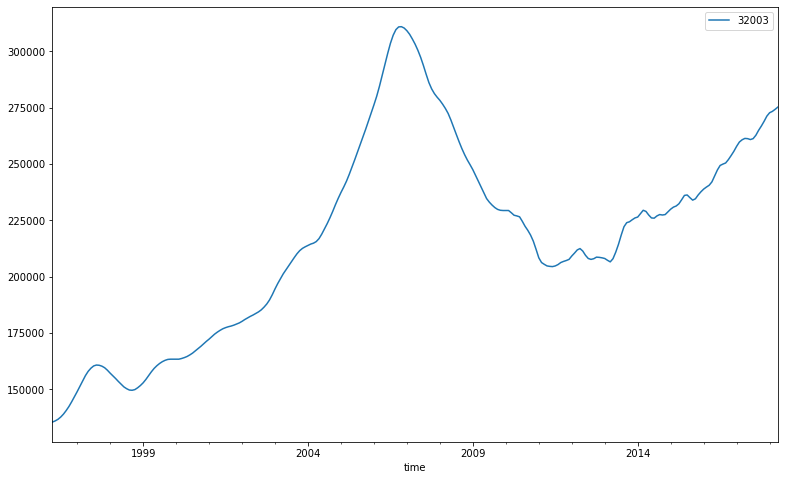

In [11]:
# visual check that the test series is working correctly

test_series = final_df[test_zip].copy()
ax = test_series.plot()
ax.legend()

### Check ACF/PACF for Test Series

#### Autocorrelation Function 

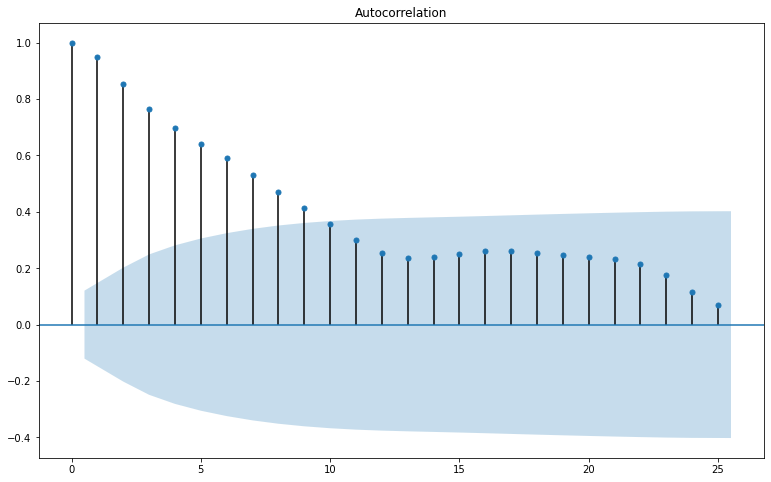

In [12]:
plot_acf(test_series.diff(1).dropna());

#### Partial Autocorrelation Function

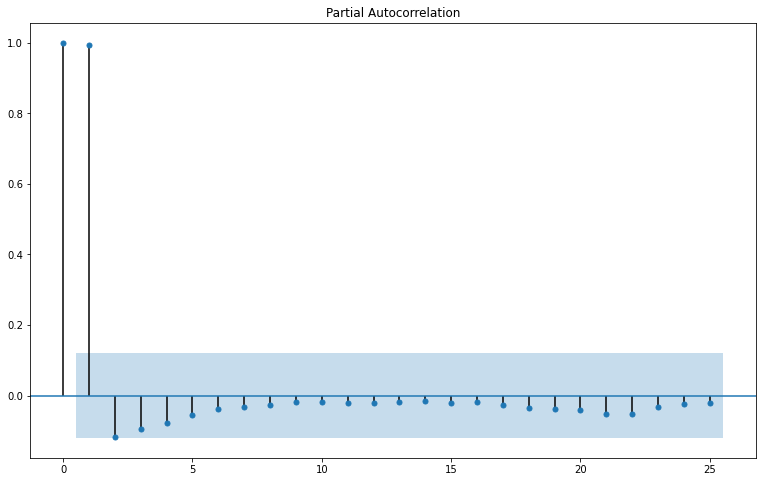

In [13]:
plot_pacf(test_series.dropna());

### Create Training and Testing Sets for Test Series

In [14]:
# split the time series into training and testing sets based on a 4:1 ratio
train_pct = 0.8
split_index = round(len(test_series)*train_pct)

In [15]:
train = test_series.iloc[:split_index]
test = test_series.iloc[split_index:]

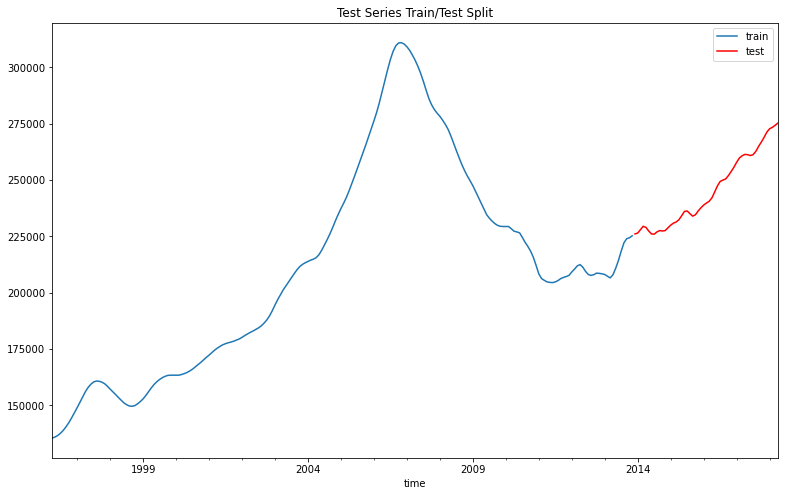

In [16]:
fig, ax = plt.subplots()
train.plot(label='train')
test.plot(label='test', color='red')
plt.title('Test Series Train/Test Split')
ax.legend();

# ARIMA Modeling

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1862.077
Date:                Wed, 30 Dec 2020   AIC                           3730.154
Time:                        01:27:53   BIC                           3740.209
Sample:                    04-30-1996   HQIC                          3734.218
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9068      0.023     38.926      0.000       0.861       0.952
ma.L1         -0.8573      0.027    -32.275      0.000      -0.909      -0.805
sigma2      2.461e+06   6.56e-10   3.75e+15      0.000    2.46e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      848.41   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               1.47   Skew:                            -0.28
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+31. Standard errors may be unstable.
"""

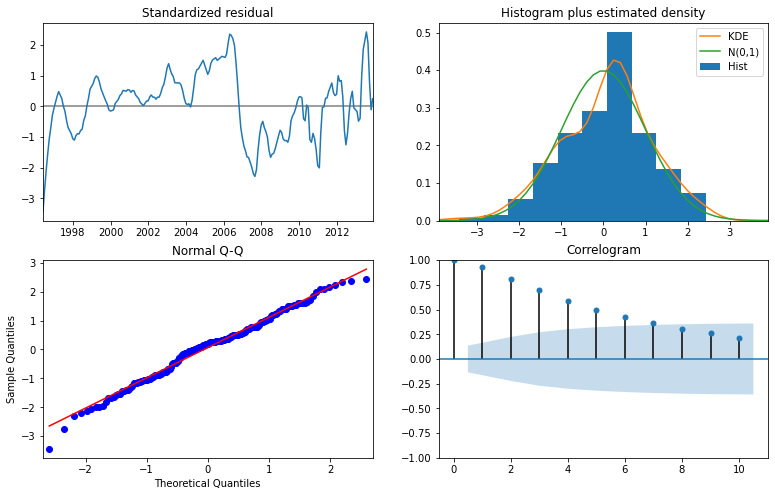

In [17]:
model = SARIMAX(train, order=(1,1,1)).fit()

display(model.summary())
model.plot_diagnostics();

In [18]:
# employs auto_arima library to find optimal p & q values using stepwise method

auto_arima_model = auto_arima(train, start_p=0, start_q=0)
#display(auto_arima_model.summary())
#auto_arima_model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  32003   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2036.985
Date:                Wed, 30 Dec 2020   AIC                           4077.970
Time:                        01:27:54   BIC                           4085.114
Sample:                    04-30-1996   HQIC                          4080.841
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0466      0.008      5.692      0.000       0.031       0.063
sigma2      3.034e+05   1.78e+04     17.010      0.000    2.68e+05    3.38e+05
===================================================================================
Ljung-Box (Q):                      164.34   Jarque-Bera (JB):                61.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

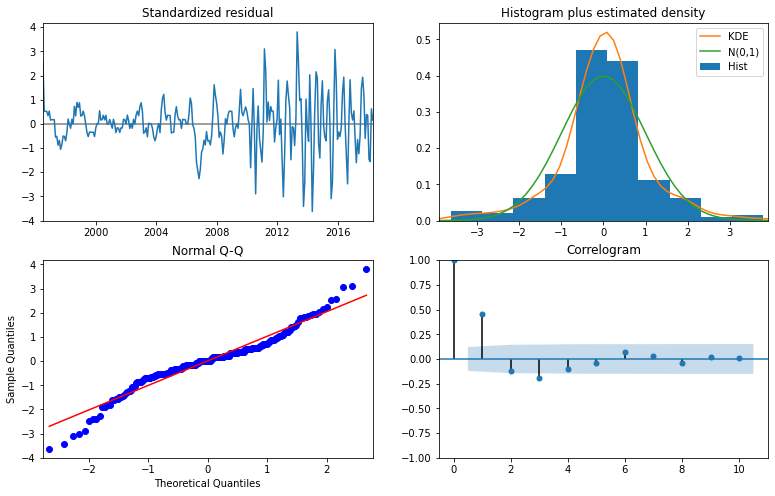

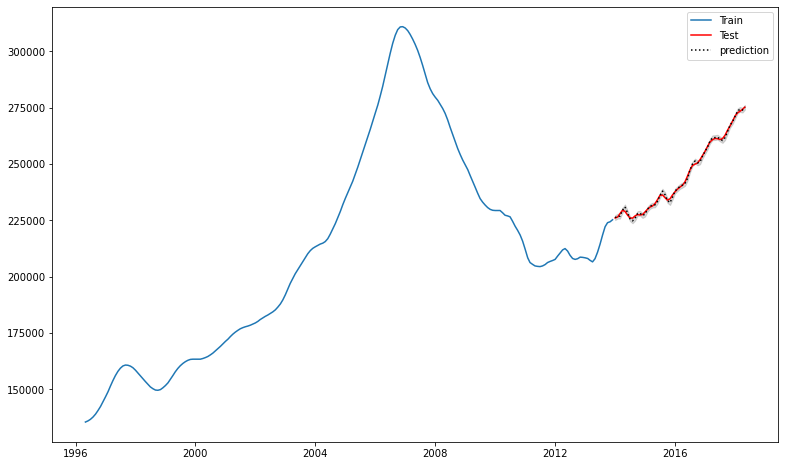

In [19]:
# creates a SARIMAX model using optimal parameters determined by auto_arima

best_model = SARIMAX(test_series, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()

display(best_model.summary())
best_model.plot_diagnostics()

prediction_best_model = best_model.get_prediction(start=test.index[0], end=test.index[-1])

prediction_df = forecast_to_dataframe(prediction_best_model, test_zip)

plot_train_test_pred(train, test, prediction_df);

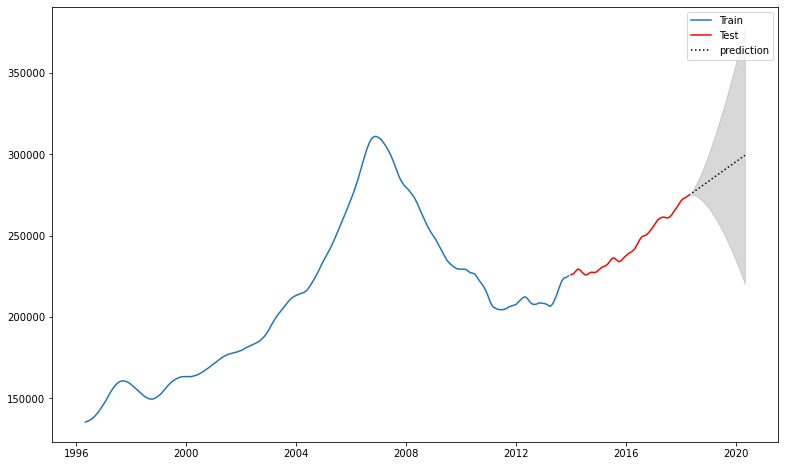

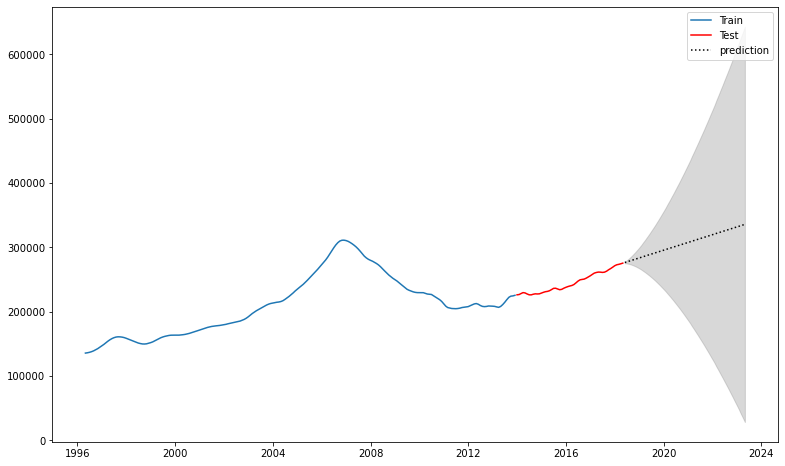

In [20]:
# creates 2 and 5 year out-of-sample forecasts for the test series

pred_2yr = best_model.get_forecast(steps=24)
pred_5yr = best_model.get_forecast(steps=60)

pred_2yr_df = forecast_to_dataframe(pred_2yr, test_zip)
pred_5yr_df = forecast_to_dataframe(pred_5yr, test_zip)

plot_train_test_pred(train, test, pred_2yr_df)
plot_train_test_pred(train, test, pred_5yr_df);

In [21]:
# creates a 2 year forecast for each unique zipcode in Florida

results = {}

for zipcode in zipcode_list:
    
    zipcode_dict = {}
    
    fl_time_series = final_df[zipcode].copy()
    
    # train/test split
    train_pct = 0.8
    split_index = round(len(fl_time_series)*train_pct)
    split_index
    
    train_ = fl_time_series.iloc[:split_index]
    test_ = fl_time_series.iloc[split_index:]
    
    
    model_ = SARIMAX(test_, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()
    
    zipcode_dict['train'] = train_
    zipcode_dict['test'] = test_
    zipcode_dict['model'] = model_
    
    pred_2yrs = model_.get_forecast(steps=24)
    pred_2yrs_df = forecast_to_dataframe(pred_2yrs, zipcode)
    zipcode_dict['upper'] = pred_2yrs_df['upper']
    zipcode_dict['lower'] = pred_2yrs_df['lower']
    zipcode_dict['prediction'] = pred_2yrs_df['prediction']
    
    results[zipcode] = zipcode_dict


In [22]:
# creates a 5 year forecast for each unique zipcode in Florida

results_5yr = {}

for zipcode in zipcode_list:
    
    zipcode_dict_5yr = {}
    
    fl_time_series_ = final_df[zipcode].copy()
    
    # train/test split
    train_pct = 0.8
    split_index = round(len(fl_time_series_)*train_pct)
    split_index
    
    train_5yr = fl_time_series_.iloc[:split_index]
    test_5yr = fl_time_series_.iloc[split_index:]
    
    
    model_5yr = SARIMAX(test_5yr, order=auto_arima_model.order,
                     seasonal_order=auto_arima_model.seasonal_order).fit()
    
    zipcode_dict_5yr['train'] = train_5yr
    zipcode_dict_5yr['test'] = test_5yr
    zipcode_dict_5yr['model'] = model_5yr
    
    pred_5yrs = model_5yr.get_forecast(steps=60)
    pred_5yrs_df = forecast_to_dataframe(pred_5yrs, zipcode)
    zipcode_dict_5yr['upper'] = pred_5yrs_df['upper']
    zipcode_dict_5yr['lower'] = pred_5yrs_df['lower']
    zipcode_dict_5yr['prediction'] = pred_5yrs_df['prediction']
    
    results_5yr[zipcode] = zipcode_dict_5yr

In [23]:
# calculates ROI for each zipcode for the 2 year horizon and appends to list as a tuple -- (ROI, zipcode)

returns_list = []

for zipcode in results:
    pct_change = (results[zipcode]['prediction'][-1] - results[zipcode]['test'][-1]) / (results[zipcode]['test'][-1]) * (100)
    returns_list.append((pct_change, zipcode))

In [24]:
# calculates ROI for each zipcode for the 5 year horizon and appends to list as a tuple -- (ROI, zipcode)

returns_list_5yr = []

for zipcode in results_5yr:
    pct_change = (results_5yr[zipcode]['prediction'][-1] - results_5yr[zipcode]['test'][-1]) / (results_5yr[zipcode]['test'][-1]) * (100)
    returns_list_5yr.append((pct_change, zipcode))

In [25]:
#sorted(returns_list_5yr, reverse=True)

#sorted(returns_list, reverse=True)

In [26]:
# creates dataframes for the top 5 returns for each time period
returns = pd.DataFrame(returns_list, columns=['return','zip'])
returns_5yr = pd.DataFrame(returns_list_5yr, columns=['return','zip'])

# saves the return dataframes to csv to be used in the map notebook
returns_5yr.to_csv('returns_5yr.csv')
returns.to_csv('returns.csv')

top_5_zips = [32621, 32461, 34449, 32455, 32625]
top_5_zips_5yr = [32320, 33701, 33704, 32680, 33181]

returns.head()

,return,zip
0,8.705691,32003
1,43.492598,32008
2,17.928997,32009
3,35.306831,32011
4,4.667238,32024


In [27]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
# try each pdq and pdqs combination for the top two year zipcodes
ans = []
for zipcode in top_5_zips:    
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(final_df[zipcode],
                                                order=combination,
                                                seasonal_order=combinations,
                                                approx=False,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([zipcode, combination, combinations, output.aic])
                #print('{} : ARIMA {} x {}12 : AIC Calculated ={}'.format(zipcode, combination, combinations, output.aic))
            except:
                continue

In [29]:
# create a dataframe with each of the pdq & pdqs combinations for the two year zipcodes
ans_df = pd.DataFrame(ans, columns=['zipcode','pdq', 'pdqs', 'aic'])

# find the pdq & pdqs combinations which minimize AIC
ans_df_final = pd.DataFrame(ans_df.loc[ans_df.groupby('zipcode')['aic'].idxmin()])

ans_df_final.set_index('zipcode', inplace=True)

ans_df_final.head()

,pdq,pdqs,aic
zipcode,,,
32455,"(1, 1, 1)","(0, 1, 1, 12)",3600.220919
32461,"(1, 1, 1)","(1, 1, 1, 12)",4737.452899
32621,"(1, 1, 1)","(1, 1, 1, 12)",3786.495259
32625,"(1, 1, 1)","(1, 1, 1, 12)",4337.591788
34449,"(1, 1, 1)","(1, 1, 1, 12)",3979.207992


In [30]:
# try each pdq and pdqs combination for the top two year zipcodes
ans_5yr = []
for zipcode in top_5_zips_5yr:    
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(final_df[zipcode],
                                                order=combination,
                                                seasonal_order=combinations,
                                                approx=False,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans_5yr.append([zipcode, combination, combinations, output.aic])
                #print('{} : ARIMA {} x {}12 : AIC Calculated ={}'.format(zipcode, combination, combinations, output.aic))
            except:
                continue

In [31]:
# create a dataframe with each of the pdq & pdqs combinations for the five year zipcodes
ans_df_5yr = pd.DataFrame(ans_5yr, columns=['zipcode','pdq', 'pdqs', 'aic'])

# find the pdq & pdqs combinations which minimize AIC
ans_df_final_5yr = pd.DataFrame(ans_df_5yr.loc[ans_df_5yr.groupby('zipcode')['aic'].idxmin()])

ans_df_final_5yr.set_index('zipcode', inplace=True)

ans_df_final_5yr.head()

,pdq,pdqs,aic
zipcode,,,
32320,"(1, 1, 1)","(1, 1, 1, 12)",3671.708013
32680,"(1, 1, 1)","(0, 1, 1, 12)",3341.664823
33181,"(1, 1, 1)","(1, 1, 1, 12)",4455.612702
33701,"(1, 1, 1)","(0, 1, 1, 12)",4027.003866
33704,"(1, 1, 1)","(1, 1, 1, 12)",3814.194373


#### Top 5 Two Year Plots 

<Figure size 936x576 with 0 Axes>

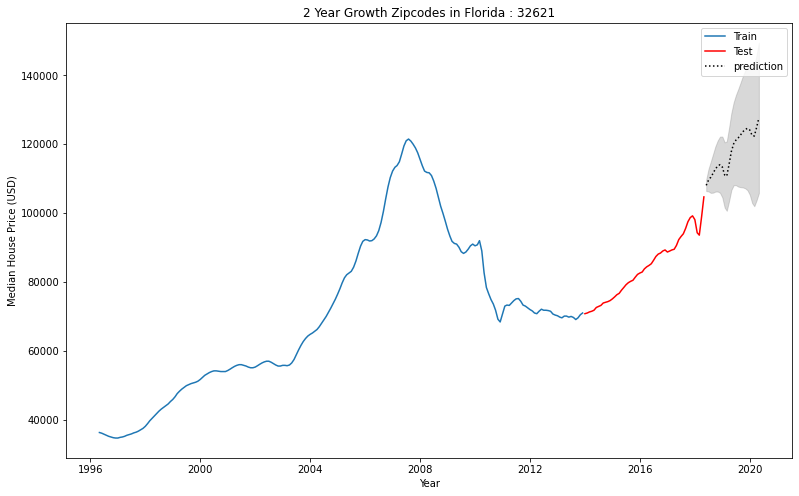

<Figure size 936x576 with 0 Axes>

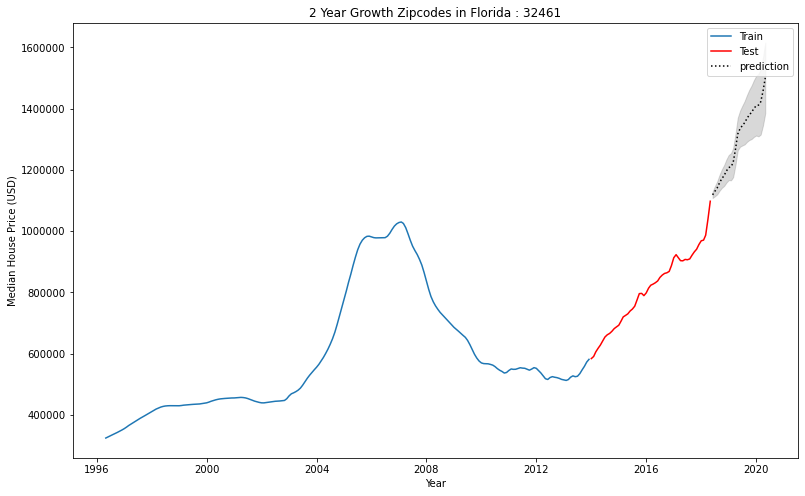

<Figure size 936x576 with 0 Axes>

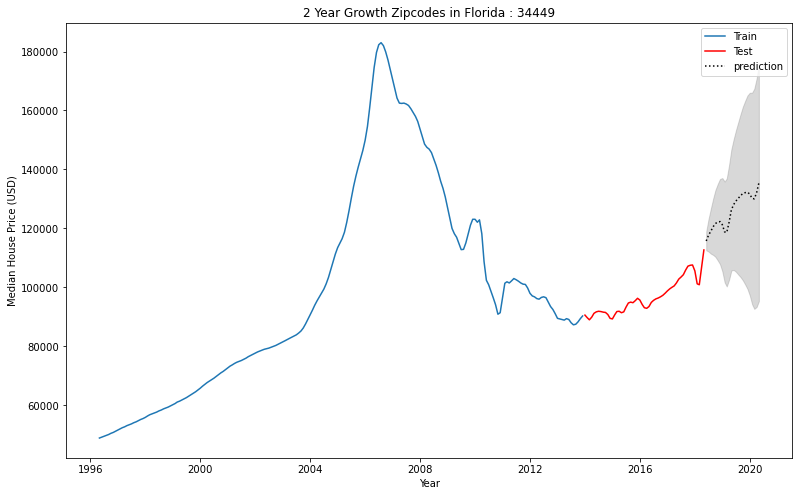

<Figure size 936x576 with 0 Axes>

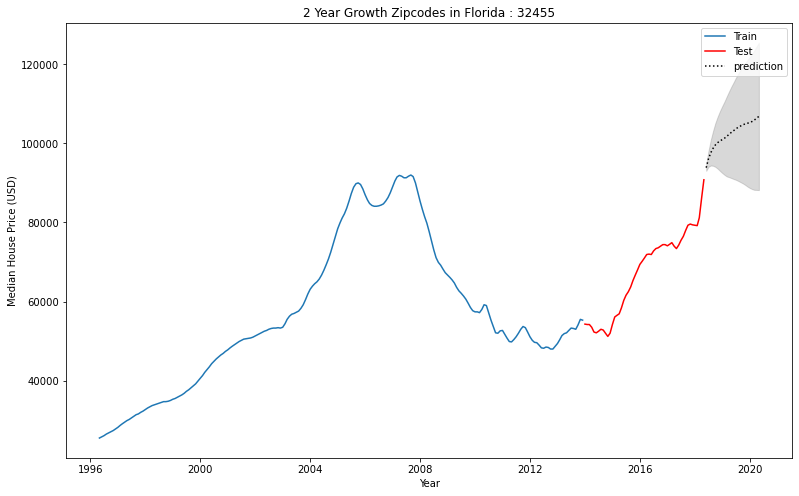

<Figure size 936x576 with 0 Axes>

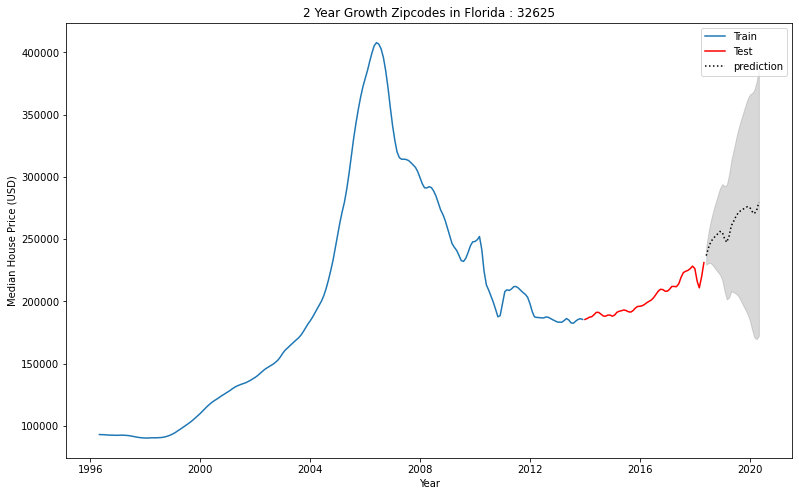

In [32]:
# create plots for each of the top 5 zipcodes, with a 2 year forecast

for _zipcode_ in top_5_zips:
    
    plt.figure()
    model = SARIMAX(final_df[_zipcode_], order=ans_df_final.loc[_zipcode_]['pdq'],
                    seasonal_order=ans_df_final.loc[_zipcode_]['pdqs']).fit()
    
    train__ = final_df[_zipcode_].iloc[:split_index]
    test__ = final_df[_zipcode_].iloc[split_index:]
    predict_2yr = model.get_forecast(steps=24)
    predict_2yr_df = forecast_to_dataframe(predict_2yr, _zipcode_)
    plot_train_test_pred(train__, test__, predict_2yr_df)
    
    plt.title('2 Year Growth Zipcodes in Florida : {}'.format(_zipcode_))
    plt.xlabel('Year')
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylabel('Median House Price (USD)');

#### Top 5 Five Year Plots 

<Figure size 936x576 with 0 Axes>

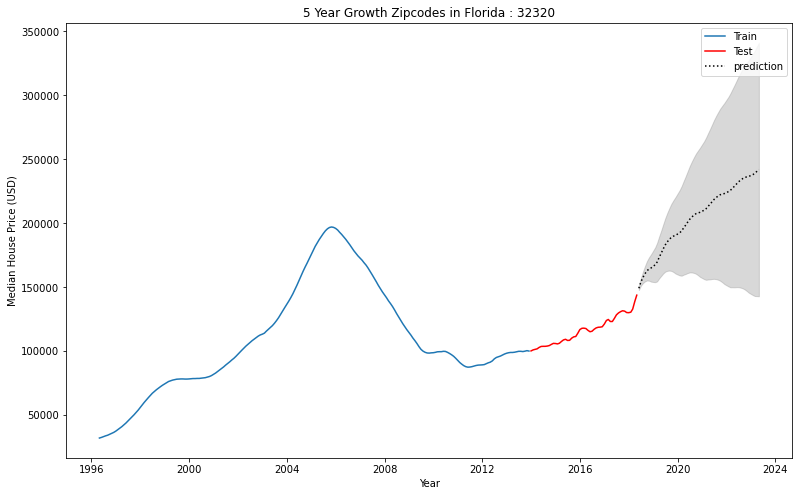

<Figure size 936x576 with 0 Axes>

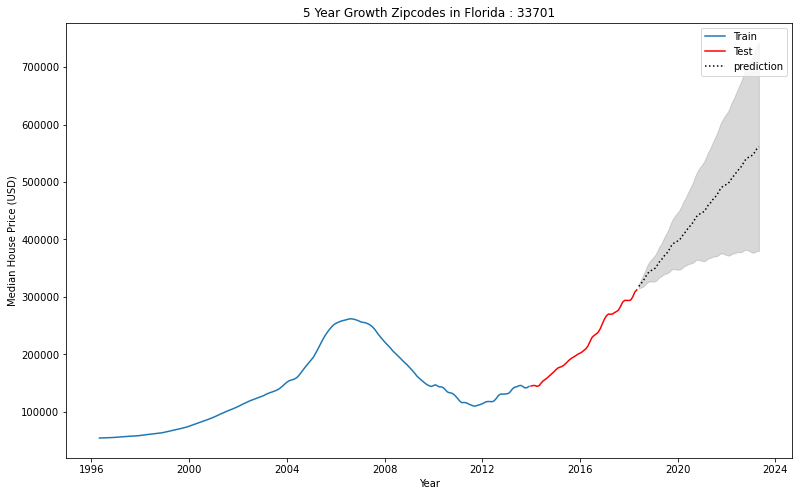

<Figure size 936x576 with 0 Axes>

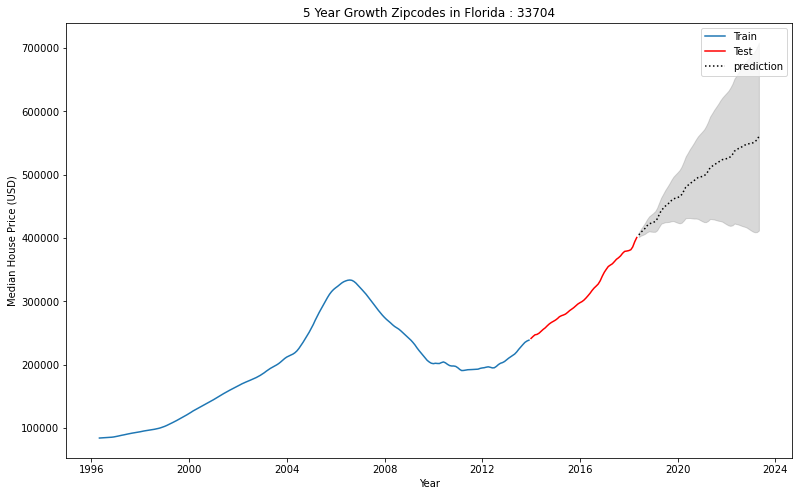

<Figure size 936x576 with 0 Axes>

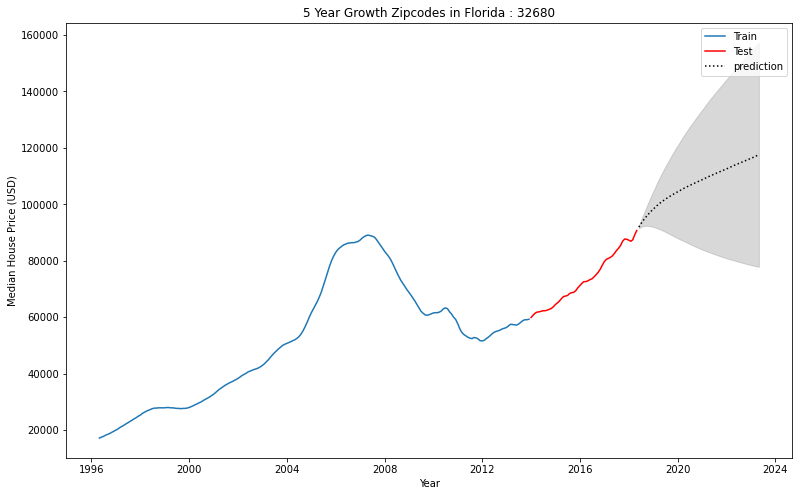

<Figure size 936x576 with 0 Axes>

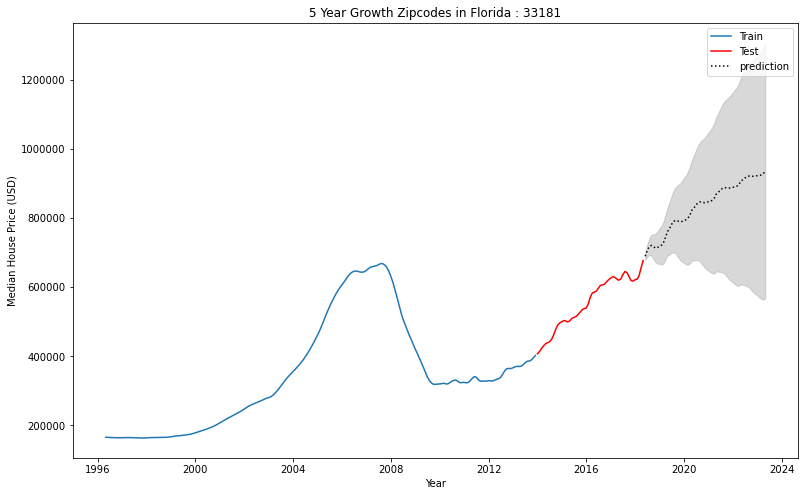

In [35]:
# create plots for each of the top 5 zipcodes, with a 5 year forecast
top_5_zips_5yr = [32320, 33701, 33704, 32680, 33181]

for zipcode in top_5_zips_5yr:
    
    plt.figure()
    model = SARIMAX(final_df[zipcode], order=ans_df_final_5yr.loc[zipcode]['pdq'],
                    seasonal_order=ans_df_final_5yr.loc[zipcode]['pdqs']).fit()
    
    train = final_df[zipcode].iloc[:split_index]
    test = final_df[zipcode].iloc[split_index:]
    predict_5yr = model.get_forecast(steps=60)
    predict_5yr_df = forecast_to_dataframe(predict_5yr, zipcode)
    plot_train_test_pred(train, test, predict_5yr_df)
    
    plt.title('5 Year Growth Zipcodes in Florida : {}'.format(zipcode))
    plt.xlabel('Year')
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylabel('Median House Price (USD)');

## ARIMA Modeling with All Zipcodes

In [36]:
# aggregates the median sale prices for each zip code, by taking a mean, into one column

fuller_df = melt_data_mean(clean_df_int_index(florida_data))
result = adfuller(fuller_df['value'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

fuller_df.head()

ADF Statistic: -1.630457
p-value: 0.467252


,value
time,
1996-04-01,104529.019608
1996-05-01,104594.117647
1996-06-01,104662.352941
1996-07-01,104727.058824
1996-08-01,104816.993464


In [37]:
# create training and testing sets for the aggregate dataframe

train_fuller = fuller_df['value'].iloc[:split_index]
test_fuller = fuller_df['value'].iloc[split_index:]

In [38]:
fuller_df.head()

,value
time,
1996-04-01,104529.019608
1996-05-01,104594.117647
1996-06-01,104662.352941
1996-07-01,104727.058824
1996-08-01,104816.993464


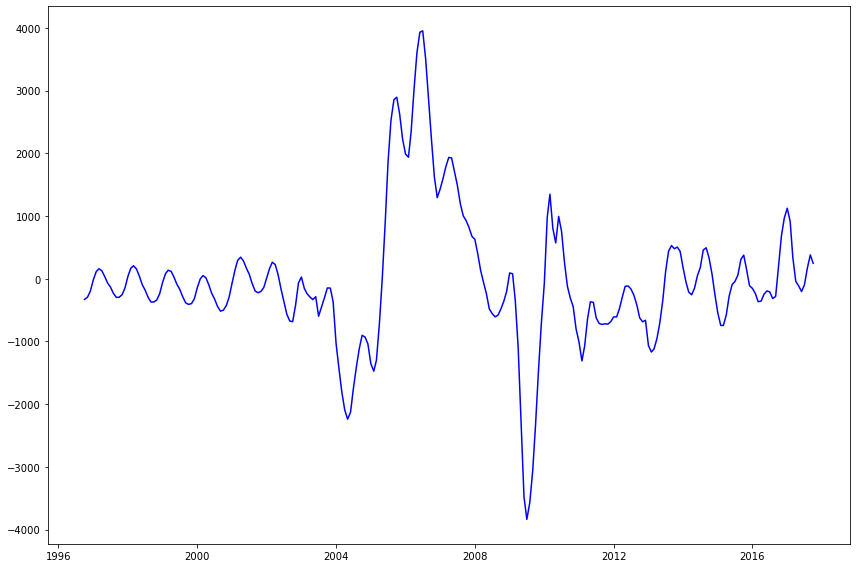

In [39]:
decomposition = sm.tsa.seasonal_decompose(fuller_df, model='additive')

residual = decomposition.resid

# Plot seasonal decomposition residuals

plt.figure(figsize=(12,8))
plt.plot(residual, label='Residuals', color='blue')
plt.tight_layout()

#### Autocorrelation Function For Aggregate Series

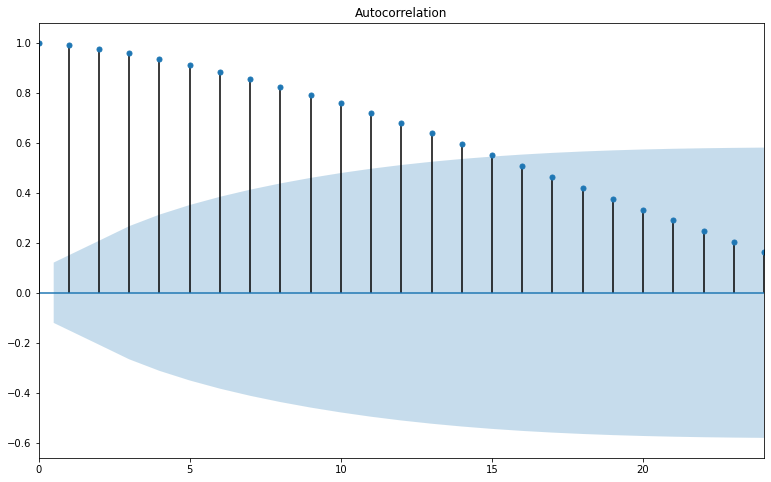

In [40]:
plot_acf(fuller_df.diff(periods=1).dropna()) 
plt.xlim(0,24)
plt.show();

#### Partial Autocorrelation Function For Aggregate Series

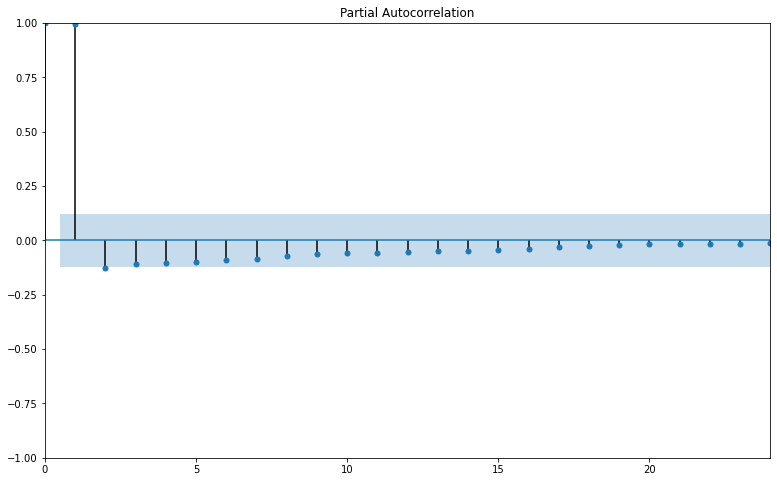

In [41]:
plot_pacf(fuller_df); plt.xlim(0,24) 
plt.ylim(-1,1)
plt.show();

In [42]:
# Create model for aggregate dataframe using optimal pdq & pdqs
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(fuller_df, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9800      0.011     89.725      0.000       0.959       1.001
ma.L1          0.3312      0.019     17.501      0.000       0.294       0.368
ar.S.L12      -0.4731      0.060     -7.853      0.000      -0.591      -0.355
ma.S.L12      15.0582      4.951      3.041      0.002       5.355      24.762
sigma2       412.2228    272.184      1.515      0.130    -121.248     945.693


In [43]:
# create intra-sample prediction from beginning of 'test' period

pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [44]:
# create forecasts for the 2 & 5 year timeframes with corresponding confidence intervals

prediction = output.get_forecast(steps=24)
prediction_5yr = output.get_forecast(steps=60)

pred_conf = prediction.conf_int( )
pred_conf_5yr = prediction_5yr.conf_int()

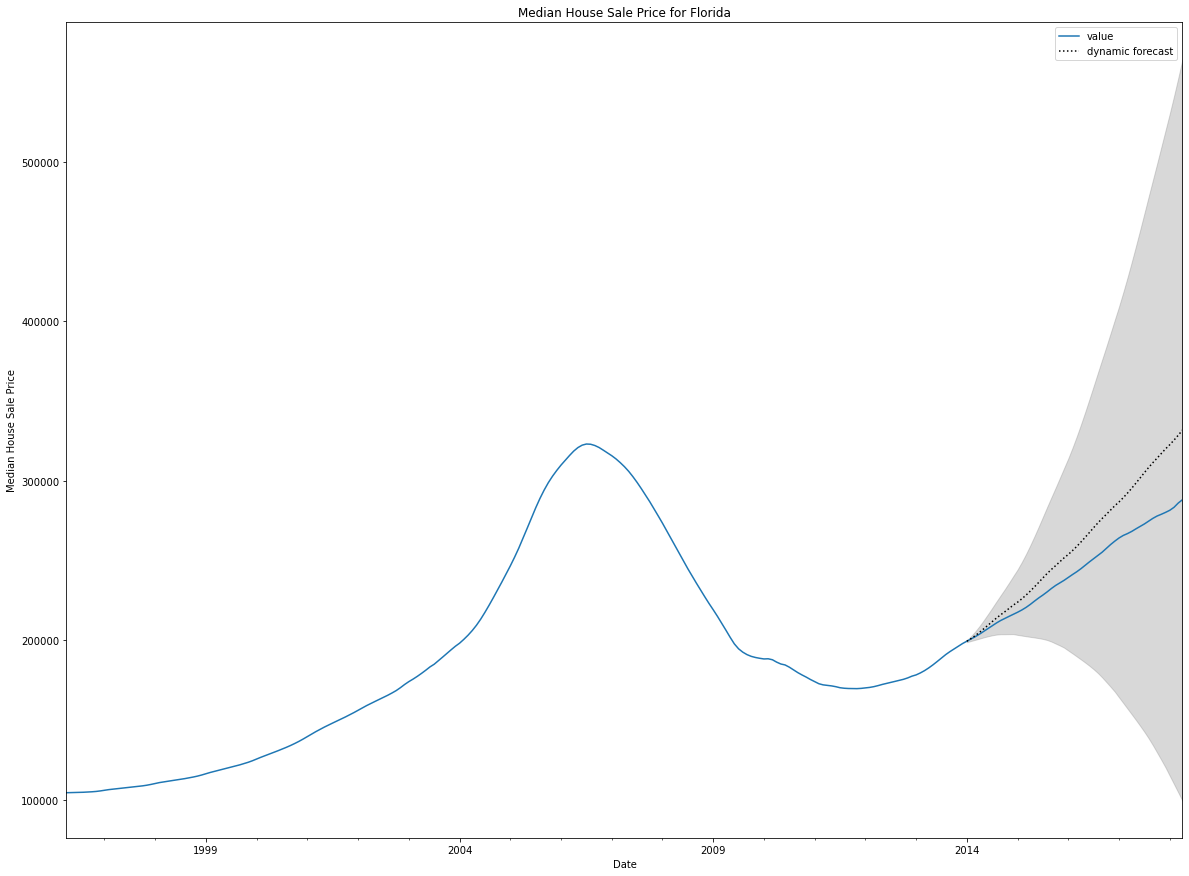

In [45]:
# Plot intra-sample prediction with confidence intervals

ax = fuller_df['1996-04-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='dynamic forecast', ax=ax, ls=':', color='black')

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='grey', alpha=.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

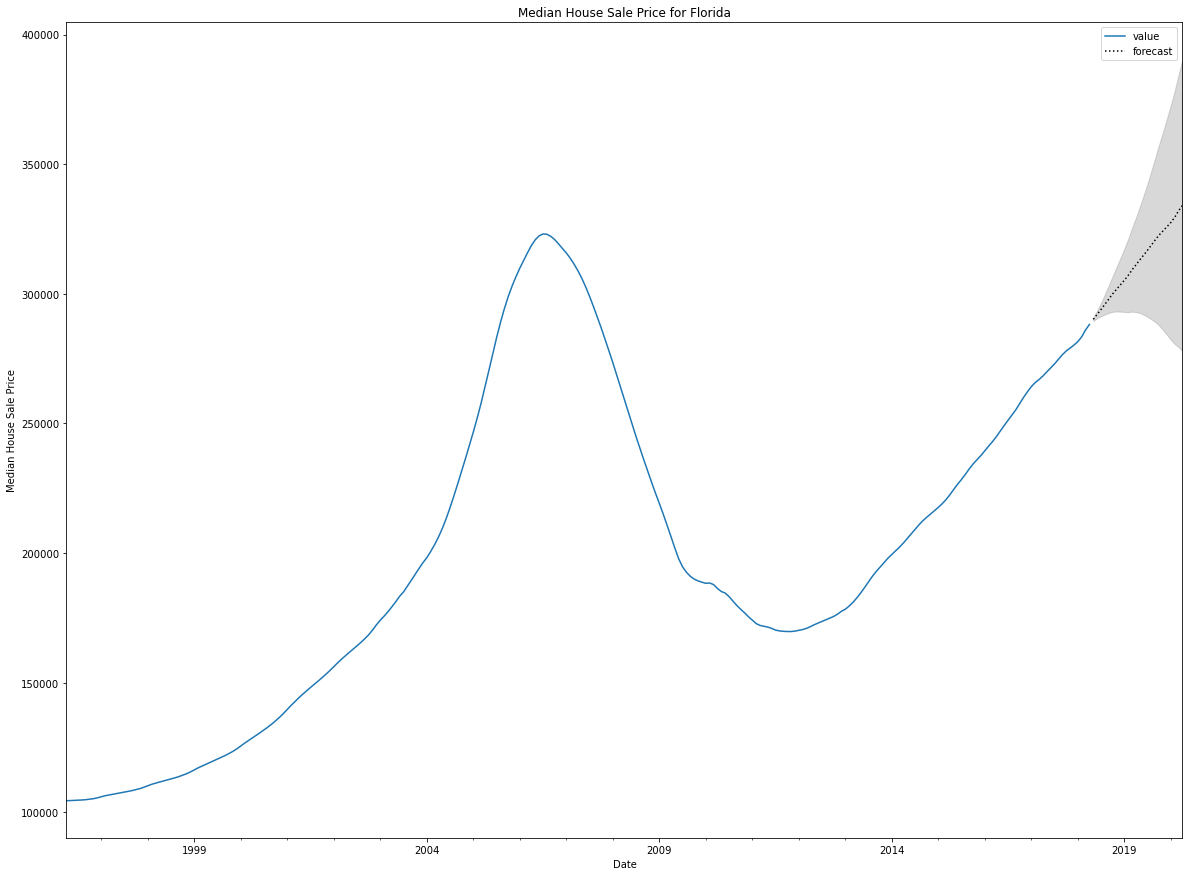

In [46]:
# Plot 2 year forecast with confidence intervals

ax = fuller_df.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='forecast', color='black', ls=':')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

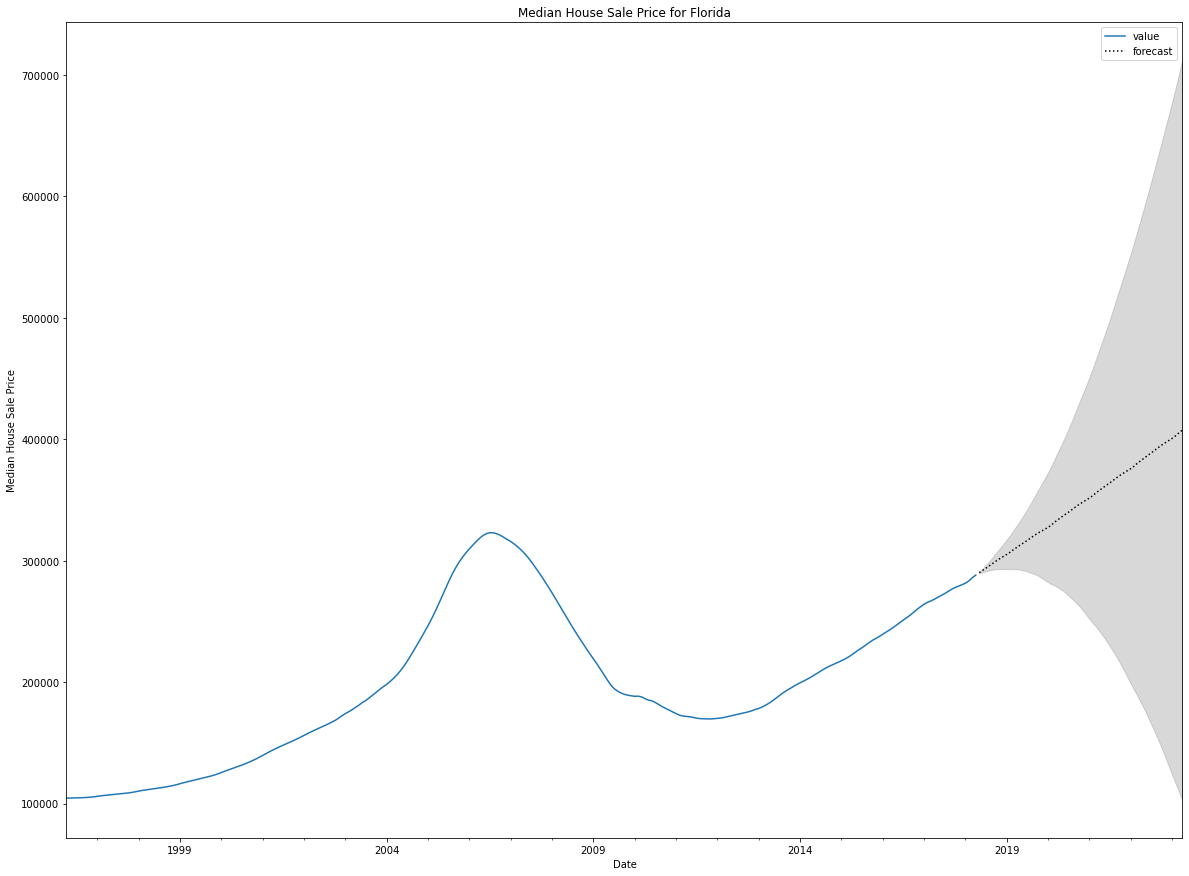

In [47]:
# Plot 5 year forecast with confidence intervals

ax = fuller_df.plot(label='observed', figsize=(20, 15))
prediction_5yr.predicted_mean.plot(ax=ax, label='forecast', color='black', ls=':')
ax.fill_between(pred_conf_5yr.index,
                pred_conf_5yr.iloc[:, 0],
                pred_conf_5yr.iloc[:, 1], color='grey', alpha=0.3)
ax.set_title('Median House Sale Price for Florida')
ax.set_xlabel('Date')
ax.set_ylabel('Median House Sale Price')

plt.legend()
plt.show()

#### Financial Crisis Plot

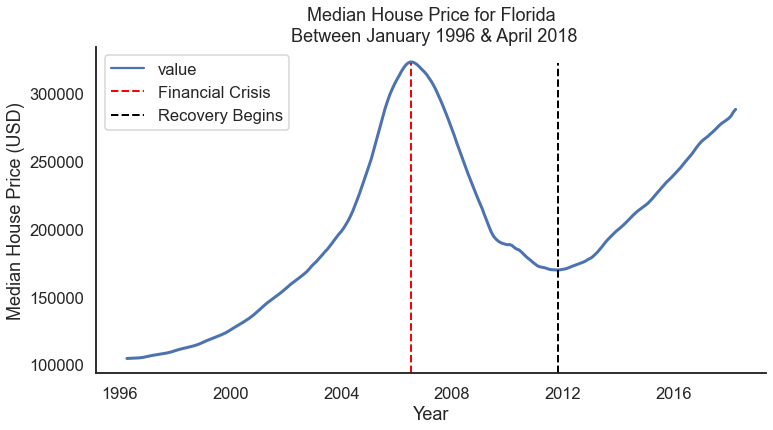

In [48]:
sns.set(rc={'figure.figsize':(12,6)},style="white", context="talk")

ax = sns.lineplot(data=fuller_df, color='g', lw=3);

# create static vertical lines marking the peak of the housing market bubble and bottom of subsequent crash
ax.axvline(x=pd.to_datetime('2006-07-14'), ymin=0, ymax=0.95, ls= "--", lw=2, color='red', label='Financial Crisis')
ax.axvline(x=pd.to_datetime('2011-11-01'), ymin=0, ymax=0.95, ls= "--", lw=2, color='black', label='Recovery Begins')

title = 'Median House Price for Florida\n Between January 1996 & April 2018'
ax.set_title(title)

xlabel = 'Year'
ylabel = "Median House Price (USD)"
ax.set(xlabel=xlabel, ylabel=ylabel)

sns.despine()
plt.legend();

### Historical Plots for Top 5 Zipcodes

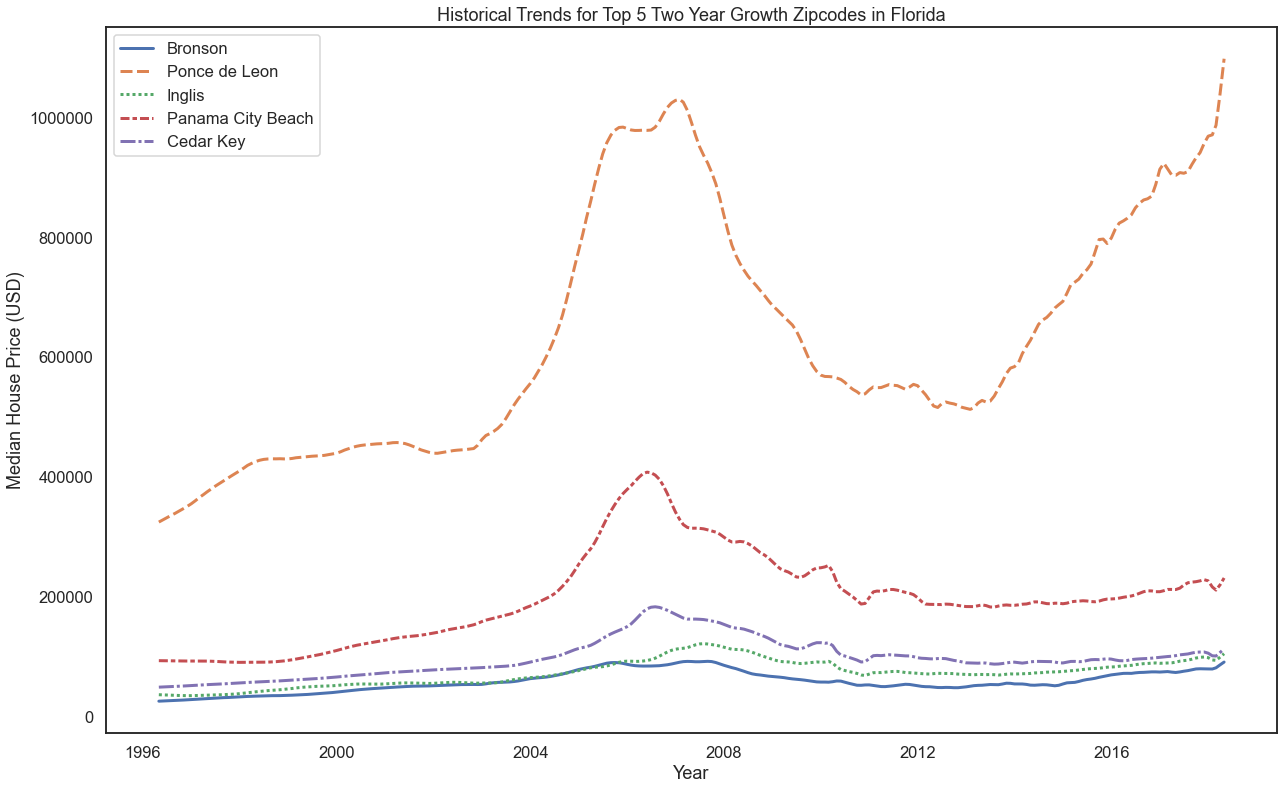

In [49]:
# create plots for top two year zipcodes of their historical data (pre-forecast)

sns.set(rc={'figure.figsize':(21,13)},style="white", context="talk")

sns.lineplot(data=final_df[top_5_zips], lw=3);

top_5_zips = [32621, 32461, 34449, 32455, 32625]

key = final_df[top_5_zips].columns
top_5_cities = []

# replace zipcodes with city names from dictionary 
get_top_cities(fl_dict_names, key)

plt.legend(top_5_cities)

plt.title('Historical Trends for Top 5 Two Year Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)')
plt.ticklabel_format(axis='y', style='plain');


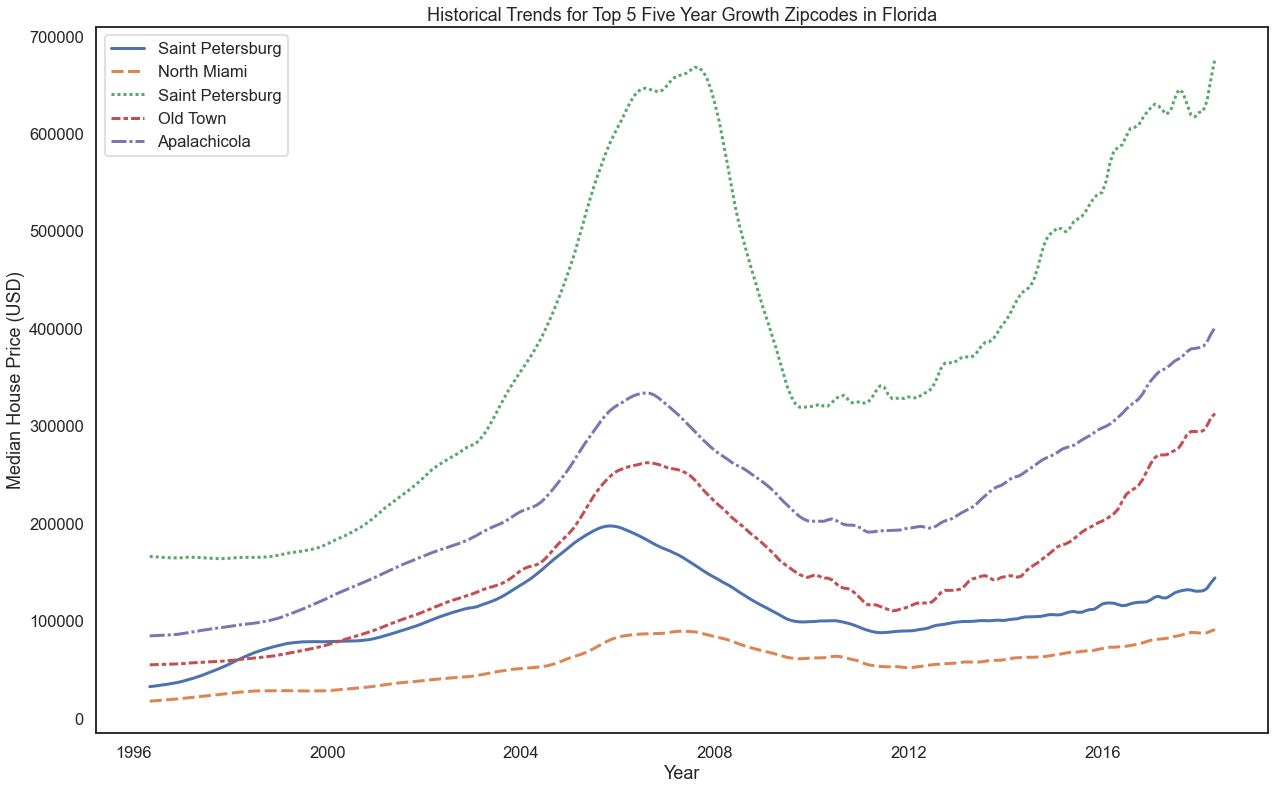

In [50]:
# create plots for top five year zipcodes of their historical data (pre-forecast)

sns.set(rc={'figure.figsize':(21,13)},style="white", context="talk")

top_5_zips_ = [32320, 33701, 33704, 32680, 33181]

sns.lineplot(data=final_df[top_5_zips_], lw=3);

key = final_df[top_5_zips_].columns
top_5_cities = []

# replace zipcodes with city names from dictionary 
get_top_cities(fl_dict_names, key)

plt.legend(top_5_cities)

plt.title('Historical Trends for Top 5 Five Year Growth Zipcodes in Florida')
plt.xlabel('Year')
plt.ylabel('Median House Price (USD)')
plt.ticklabel_format(axis='y', style='plain');